# Análise de Imagens Sentinel para o Protótipo NAIÁ

Este notebook analisa as imagens Sentinel-1 (VV/VH) e Sentinel-2 (RGB+NIR) recortadas por setores censitários urbanos de Barão Geraldo, Campinas (SP), no contexto do Hackathon CopernicusLAC Panamá 2025 (Dia 1, 21:09, 29/07/2025, -03). O objetivo é:
1. Calcular métricas por setor censitário:
   - **Sentinel-1**: Backscatter médio (VV e VH) em dB.
   - **Sentinel-2**: NDVI médio (usando bandas NIR e Red).
2. Salvar resultados em `data/processed/metrics.csv`.
3. Gerar gráficos de validação (histogramas de NDVI e backscatter).

## Configuração
- **Ambiente**: `naia-env` (Python 3.12.7).
- **Repositório**: `/home/lorhan/git/CorpenicusHackthon/`.
- **Entradas**:
  - `data/processed/s1_setor_<CD_SETOR>.tiff` (Sentinel-1, VV/VH, 2 bandas).
  - `data/processed/s2_setor_<CD_SETOR>.tiff` (Sentinel-2, RGB+NIR, 4 bandas).
  - `data/area_prova_barao.geojson` (setores censitários).
- **Saídas**:
  - `data/processed/metrics.csv`: Tabela com `CD_SETOR`, `VV_mean_dB`, `VH_mean_dB`, `NDVI_mean`.
  - `data/processed/ndvi_histogram.png`: Histograma de NDVI médio.
  - `data/processed/vv_histogram.png`: Histograma de backscatter VV médio.
  - `data/processed/vh_histogram.png`: Histograma de backscatter VH médio.

## Pré-requisitos
1. Ative o ambiente: `source naia-env/bin/activate`.
2. Instale dependências:
   ```bash
   pip install geopandas rasterio matplotlib pandas numpy
   pip freeze > requirements.txt
   ```
3. Execute `preprocess.ipynb` para gerar os TIFFs recortados.
4. Verifique a existência de `data/area_prova_barao.geojson`.
5. Execute as células sequencialmente.

In [1]:
# Importações
import os
import geopandas as gpd
import rasterio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob

# Configurar diretórios
os.makedirs('data/processed', exist_ok=True)
print('✓ Diretório data/processed/ criado ou já existente')

# Definir caminhos
sectors_path = 'data/area_prova_barao.geojson'
s1_pattern = 'data/processed/s1_setor_*.tiff'
s2_pattern = 'data/processed/s2_setor_*.tiff'

# Verificar arquivos de entrada
print('\n--- Verificando arquivos de entrada ---')
s1_files = glob.glob(s1_pattern)
s2_files = glob.glob(s2_pattern)
print(f'✓ Encontrados {len(s1_files)} arquivos Sentinel-1 recortados')
print(f'✓ Encontrados {len(s2_files)} arquivos Sentinel-2 recortados')
if os.path.exists(sectors_path):
    size_mb = os.path.getsize(sectors_path) / (1024 * 1024)
    print(f'✓ {sectors_path} ({size_mb:.1f} MB)')
else:
    print(f'❌ {sectors_path} não encontrado')

✓ Diretório data/processed/ criado ou já existente

--- Verificando arquivos de entrada ---
✓ Encontrados 88 arquivos Sentinel-1 recortados
✓ Encontrados 88 arquivos Sentinel-2 recortados
✓ data/area_prova_barao.geojson (0.3 MB)


## 1. Carregamento dos Setores Censitários

Carregamos `data/area_prova_barao.geojson` e filtramos setores com TIFFs disponíveis.

In [2]:
try:
    sectors_gdf = gpd.read_file(sectors_path)
    print(f'✓ GeoJSON de setores carregado: {len(sectors_gdf)} setores censitários')
    print(f'  Colunas disponíveis: {list(sectors_gdf.columns)}')
    if 'CD_SETOR' not in sectors_gdf.columns:
        raise ValueError('Coluna CD_SETOR não encontrada no GeoJSON')
    # Filtrar setores urbanos com área <= 1.0 km²
    sectors_gdf_urban = sectors_gdf[(sectors_gdf['SITUACAO'] == 'Urbana') & (sectors_gdf['AREA_KM2'] <= 1.0)]
    print(f'✓ Setores filtrados: {len(sectors_gdf_urban)} setores urbanos com área ≤ 1.0 km²')
    if len(sectors_gdf_urban) == 0:
        raise ValueError('Nenhum setor urbano encontrado após filtro')
    # Extrair IDs de setores com TIFFs disponíveis
    s1_ids = {os.path.basename(f).replace('s1_setor_', '').replace('.tiff', '') for f in s1_files}
    s2_ids = {os.path.basename(f).replace('s2_setor_', '').replace('.tiff', '') for f in s2_files}
    sector_ids = s1_ids.intersection(s2_ids)  # Setores com ambos S1 e S2
    print(f'✓ IDs de setores com TIFFs disponíveis: {len(sector_ids)}')
    # Filtrar GeoDataFrame para setores com TIFFs
    sectors_gdf_urban = sectors_gdf_urban[sectors_gdf_urban['CD_SETOR'].astype(str).isin(sector_ids)]
    print(f'✓ Setores filtrados com TIFFs: {len(sectors_gdf_urban)}')
except Exception as e:
    print(f'❌ Erro ao carregar {sectors_path}: {e}')
    sectors_gdf_urban = None

✓ GeoJSON de setores carregado: 137 setores censitários
  Colunas disponíveis: ['CD_SETOR', 'SITUACAO', 'CD_SIT', 'CD_TIPO', 'AREA_KM2', 'CD_REGIAO', 'NM_REGIAO', 'CD_UF', 'NM_UF', 'CD_MUN', 'NM_MUN', 'CD_DIST', 'NM_DIST', 'CD_SUBDIST', 'NM_SUBDIST', 'CD_BAIRRO', 'NM_BAIRRO', 'CD_NU', 'NM_NU', 'CD_FCU', 'NM_FCU', 'CD_AGLOM', 'NM_AGLOM', 'CD_RGINT', 'NM_RGINT', 'CD_RGI', 'NM_RGI', 'CD_CONCURB', 'NM_CONCURB', 'geometry']
✓ Setores filtrados: 128 setores urbanos com área ≤ 1.0 km²
✓ IDs de setores com TIFFs disponíveis: 88
✓ Setores filtrados com TIFFs: 88


## 2. Cálculo das Métricas por Setor

Calculamos o backscatter médio (VV e VH) para Sentinel-1 e o NDVI médio para Sentinel-2.

In [3]:
def calculate_metrics(s1_files, s2_files, sector_ids):
    """Calcula métricas por setor censitário."""
    metrics = []
    s1_files_set = set(s1_files)
    s2_files_set = set(s2_files)
    for cd_setor in sector_ids:
        s1_file = f'data/processed/s1_setor_{cd_setor}.tiff'
        s2_file = f'data/processed/s2_setor_{cd_setor}.tiff'
        metric = {'CD_SETOR': cd_setor}

        # Processar Sentinel-1 (VV/VH)
        if s1_file in s1_files_set:
            try:
                with rasterio.open(s1_file) as src:
                    data = src.read()
                    if data.shape[0] >= 2:  # VV e VH
                        vv = data[0]
                        vh = data[1]
                        # Converter para dB (log10)
                        vv_db = 10 * np.log10(vv + 1e-10)
                        vh_db = 10 * np.log10(vh + 1e-10)
                        # Médias, ignorando zeros
                        vv_mean = np.nanmean(vv_db[vv_db > -100]) if np.any(vv_db > -100) else np.nan
                        vh_mean = np.nanmean(vh_db[vh_db > -100]) if np.any(vh_db > -100) else np.nan
                        metric['VV_mean_dB'] = vv_mean
                        metric['VH_mean_dB'] = vh_mean
                        print(f'✓ Processado S1: {cd_setor} (VV={vv_mean:.2f} dB, VH={vh_mean:.2f} dB)')
                    else:
                        print(f'⚠️ {s1_file} tem menos de 2 bandas')
                        metric['VV_mean_dB'] = np.nan
                        metric['VH_mean_dB'] = np.nan
            except Exception as e:
                print(f'❌ Erro ao processar {s1_file}: {e}')
                metric['VV_mean_dB'] = np.nan
                metric['VH_mean_dB'] = np.nan
        else:
            metric['VV_mean_dB'] = np.nan
            metric['VH_mean_dB'] = np.nan

        # Processar Sentinel-2 (NDVI)
        if s2_file in s2_files_set:
            try:
                with rasterio.open(s2_file) as src:
                    data = src.read()
                    if data.shape[0] >= 4:  # R, G, B, NIR
                        red = data[0].astype(float)
                        nir = data[3].astype(float)
                        # Calcular NDVI: (NIR - Red) / (NIR + Red)
                        ndvi = (nir - red) / (nir + red + 1e-10)
                        # Média, ignorando valores inválidos
                        ndvi_mean = np.nanmean(ndvi[(ndvi >= -1) & (ndvi <= 1)]) if np.any((ndvi >= -1) & (ndvi <= 1)) else np.nan
                        metric['NDVI_mean'] = ndvi_mean
                        print(f'✓ Processado S2: {cd_setor} (NDVI={ndvi_mean:.3f})')
                    else:
                        print(f'⚠️ {s2_file} tem menos de 4 bandas')
                        metric['NDVI_mean'] = np.nan
            except Exception as e:
                print(f'❌ Erro ao processar {s2_file}: {e}')
                metric['NDVI_mean'] = np.nan
        else:
            metric['NDVI_mean'] = np.nan

        metrics.append(metric)
    return pd.DataFrame(metrics)

if sectors_gdf_urban is not None:
    print('\n--- Calculando métricas por setor ---')
    metrics_df = calculate_metrics(s1_files, s2_files, sector_ids)
    output_csv = 'data/processed/metrics.csv'
    metrics_df.to_csv(output_csv, index=False)
    print(f'✓ Métricas salvas em {output_csv}')
else:
    print('❌ Pulando cálculo de métricas devido a falha no carregamento dos setores')


--- Calculando métricas por setor ---
✓ Processado S1: 350950210000095 (VV=15.34 dB, VH=10.01 dB)
✓ Processado S2: 350950210000095 (NDVI=0.169)
✓ Processado S1: 350950210000068 (VV=16.72 dB, VH=11.50 dB)
✓ Processado S2: 350950210000068 (NDVI=0.156)
✓ Processado S1: 350950210000090 (VV=16.24 dB, VH=10.87 dB)
✓ Processado S2: 350950210000090 (NDVI=0.147)
✓ Processado S1: 350950210000176 (VV=15.74 dB, VH=8.60 dB)
✓ Processado S2: 350950210000176 (NDVI=0.155)
✓ Processado S1: 350950210000144 (VV=15.40 dB, VH=9.40 dB)
✓ Processado S2: 350950210000144 (NDVI=0.073)
✓ Processado S1: 350950210000056 (VV=15.98 dB, VH=10.74 dB)
✓ Processado S2: 350950210000056 (NDVI=0.186)
✓ Processado S1: 350950210000148 (VV=15.77 dB, VH=11.00 dB)
✓ Processado S2: 350950210000148 (NDVI=0.092)
✓ Processado S1: 350950210000151 (VV=15.10 dB, VH=9.29 dB)
✓ Processado S2: 350950210000151 (NDVI=0.281)
✓ Processado S1: 350950210000143 (VV=15.82 dB, VH=10.95 dB)
✓ Processado S2: 350950210000143 (NDVI=0.140)
✓ Processa

## 3. Validação com Gráficos

Geramos histogramas para visualizar a distribuição de NDVI e backscatter.

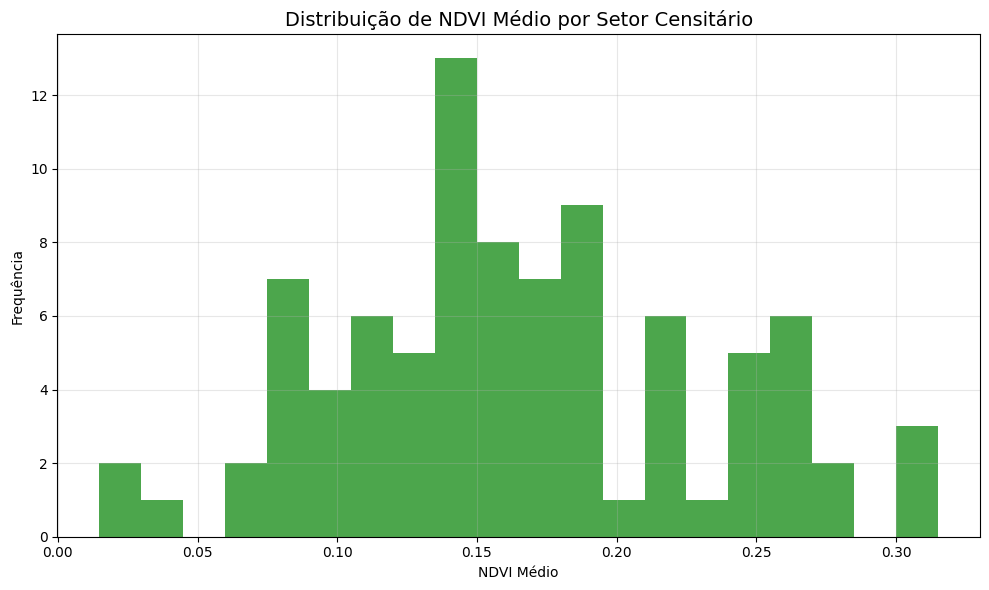

✓ Histograma de NDVI salvo em data/processed/ndvi_histogram.png


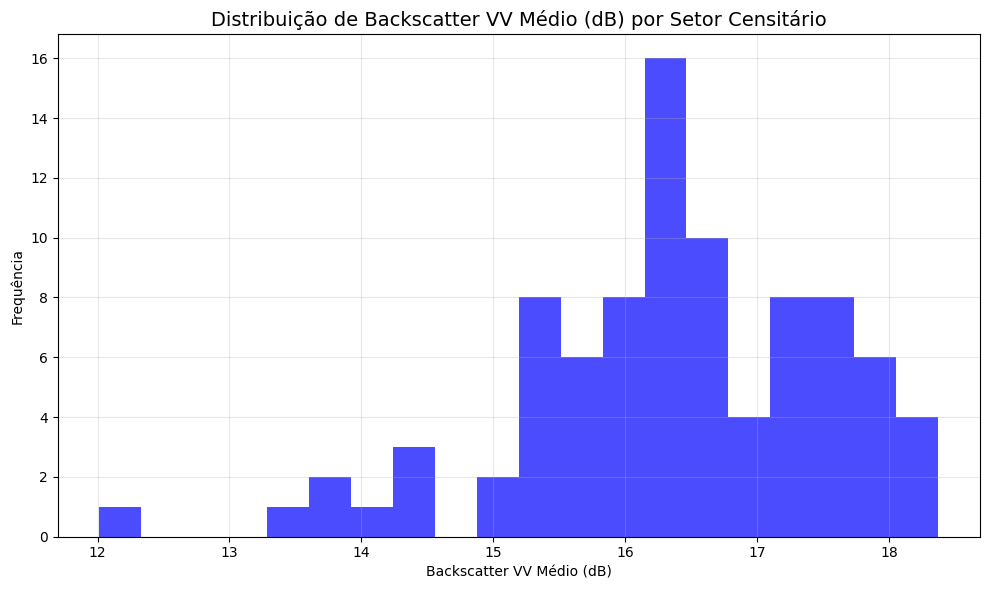

✓ Histograma de VV salvo em data/processed/vv_histogram.png


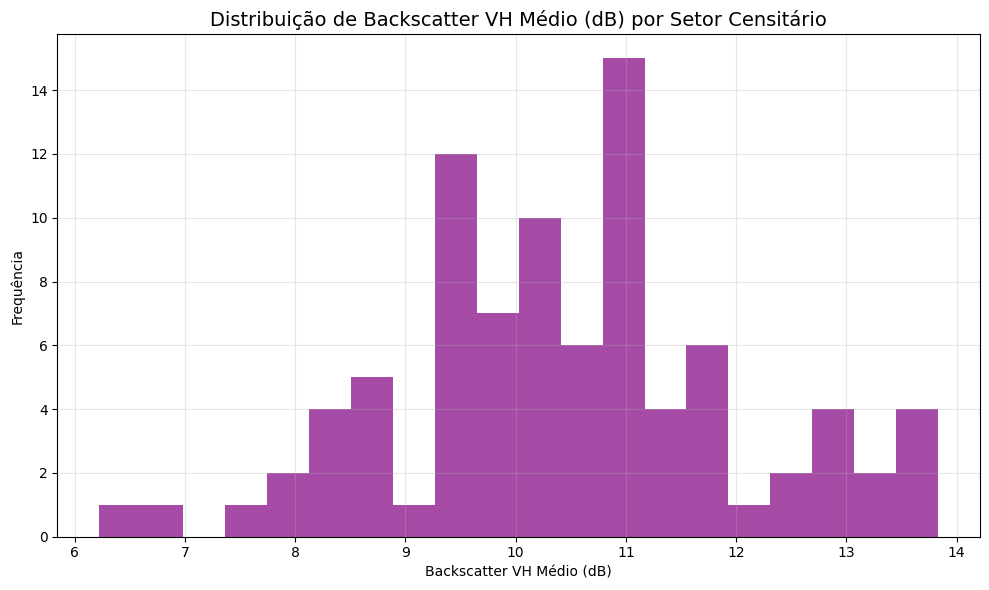

✓ Histograma de VH salvo em data/processed/vh_histogram.png


In [4]:
if 'metrics_df' in locals() and not metrics_df.empty:
    # Histograma de NDVI
    plt.figure(figsize=(10, 6))
    plt.hist(metrics_df['NDVI_mean'].dropna(), bins=20, color='green', alpha=0.7)
    plt.title('Distribuição de NDVI Médio por Setor Censitário', fontsize=14)
    plt.xlabel('NDVI Médio')
    plt.ylabel('Frequência')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('data/processed/ndvi_histogram.png', dpi=300, bbox_inches='tight')
    plt.show()
    print('✓ Histograma de NDVI salvo em data/processed/ndvi_histogram.png')

    # Histograma de VV (Sentinel-1)
    plt.figure(figsize=(10, 6))
    plt.hist(metrics_df['VV_mean_dB'].dropna(), bins=20, color='blue', alpha=0.7)
    plt.title('Distribuição de Backscatter VV Médio (dB) por Setor Censitário', fontsize=14)
    plt.xlabel('Backscatter VV Médio (dB)')
    plt.ylabel('Frequência')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('data/processed/vv_histogram.png', dpi=300, bbox_inches='tight')
    plt.show()
    print('✓ Histograma de VV salvo em data/processed/vv_histogram.png')

    # Histograma de VH (Sentinel-1)
    plt.figure(figsize=(10, 6))
    plt.hist(metrics_df['VH_mean_dB'].dropna(), bins=20, color='purple', alpha=0.7)
    plt.title('Distribuição de Backscatter VH Médio (dB) por Setor Censitário', fontsize=14)
    plt.xlabel('Backscatter VH Médio (dB)')
    plt.ylabel('Frequência')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('data/processed/vh_histogram.png', dpi=300, bbox_inches='tight')
    plt.show()
    print('✓ Histograma de VH salvo em data/processed/vh_histogram.png')
else:
    print('❌ Pulando gráficos devido a falha no cálculo de métricas')

## 4. Resumo da Execução

Resumimos o status da análise.

In [5]:
print('\n' + '='*50)
print('📋 RESUMO DA EXECUÇÃO')
print('='*50)
print(f'✓ Setores urbanos processados: {len(sectors_gdf_urban) if sectors_gdf_urban is not None else 0}')
print(f'✓ Arquivos Sentinel-1 processados: {len(s1_files)}')
print(f'✓ Arquivos Sentinel-2 processados: {len(s2_files)}')
if 'metrics_df' in locals():
    print(f'✓ Setores com métricas calculadas: {len(metrics_df)}')
    print(f'✓ Setores com TIFFs ausentes: {len(sector_ids) - len(metrics_df[metrics_df[["VV_mean_dB", "VH_mean_dB", "NDVI_mean"]].notna().all(axis=1)])}')
    print(f'✓ Média NDVI: {metrics_df["NDVI_mean"].mean():.3f}')
    print(f'✓ Média VV (dB): {metrics_df["VV_mean_dB"].mean():.2f}')
    print(f'✓ Média VH (dB): {metrics_df["VH_mean_dB"].mean():.2f}')

print('\n🗂️ ARQUIVOS GERADOS:')
for file in glob.glob('data/processed/*.csv') + glob.glob('data/processed/*_histogram.png'):
    if os.path.exists(file):
        print(f'  ✓ {file} (Tamanho: {os.path.getsize(file) / 1024 / 1024:.2f} MB)')


📋 RESUMO DA EXECUÇÃO
✓ Setores urbanos processados: 88
✓ Arquivos Sentinel-1 processados: 88
✓ Arquivos Sentinel-2 processados: 88
✓ Setores com métricas calculadas: 88
✓ Setores com TIFFs ausentes: 0
✓ Média NDVI: 0.165
✓ Média VV (dB): 16.36
✓ Média VH (dB): 10.46

🗂️ ARQUIVOS GERADOS:
  ✓ data/processed/metrics.csv (Tamanho: 0.01 MB)
  ✓ data/processed/ndvi_histogram.png (Tamanho: 0.08 MB)
  ✓ data/processed/vv_histogram.png (Tamanho: 0.10 MB)
  ✓ data/processed/vh_histogram.png (Tamanho: 0.10 MB)
